In [7]:
import argparse
import os
import sys
import yaml
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from thop import profile
from tqdm import tqdm
import math
import csv
import numpy as np

# Add the parent directory of 'models' to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from networks.unet import UNet
from networks.attention_unet import AttnUNet
import src.data_utils as data_utils
from src.metrics import dice_loss, dice_coefficient

In [10]:
# which run to visualize
run_dir = "../runs/unet_0727_1906"
yaml_path = os.path.join(run_dir, 'summary.yaml')
csv_path = os.path.join(run_dir, 'metrics.csv')

In [ ]:
# Generate a new fake csv metrics file

# import random
# output_file = '/Users/liubodong/Documents/dev/AI/U-Nets/test_plot/metrics.csv'
# num_epochs = 100
# with open(output_file, 'w', newline='') as fout:
#     writer = csv.writer(fout)
#     writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_dice'])
#     for epoch in range(1, num_epochs):
#         # Inverse-like loss: start high, decrease, add small noise
#         train_loss = 0.7 / (1 + 0.08 * epoch)
#         train_loss += random.uniform(-0.1 * train_loss, 0.1 * train_loss)
#         val_loss = 0.75 / (1 + 0.06 * epoch)
#         val_loss += random.uniform(-0.1 * val_loss, 0.1 * val_loss)
#         # Dice: sqrt-like, starts low, increases, add small noise
#         val_dice = min(0.98, 1 - 0.9 / (1 + 0.08 * epoch))
#         val_dice += random.uniform(-0.03 / val_dice, 0.03 / val_dice)
                        
#         writer.writerow([
#             epoch,
#             round(train_loss, 4),
#             round(val_loss, 4),
#             round(val_dice, 4)
#         ])



In [ ]:
with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)


with open(csv_path, 'r') as f:
    history = list(csv.DictReader(f))
    
best_epoch_metrics = max(history, key=lambda x: x['val_dice'])

# make best_epoch_metrics a dictionary with correct types
best_epoch_metrics = {
    'epoch': int(best_epoch_metrics['epoch']),
    'val_dice': float(best_epoch_metrics['val_dice']),
    'train_loss': float(best_epoch_metrics['train_loss']),
    'val_loss': float(best_epoch_metrics['val_loss'])
}



C:\Users\lbd\AppData\Local\Temp\ipykernel_28976\2995196963.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(bottom=0, top=y1_top)


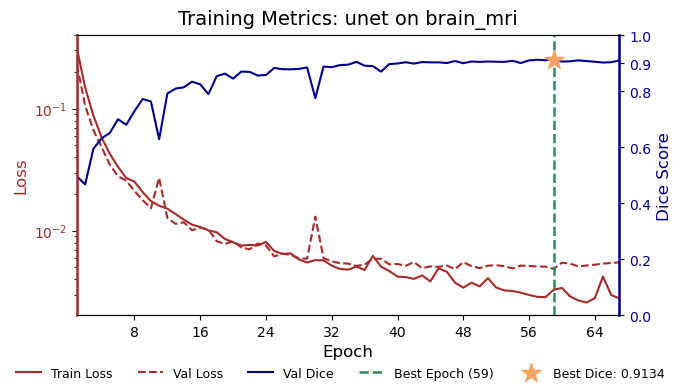

In [26]:
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


metrics_df = pd.read_csv(csv_path)

# 3. Plot and save metrics
plt.style.use('petroff10')

x   = metrics_df['epoch']
y11 = metrics_df['train_loss']
y12 = metrics_df['val_loss']
y2  = metrics_df['val_dice']


fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot Loss
ax1.set_xlabel('Epoch', fontsize=12, loc='center')
ax1.set_ylabel('Loss', color='brown', fontsize=12)


use_log = True

if use_log:
    ax1.semilogy(x, y11, '-', color='brown', label='Train Loss')
    ax1.semilogy(x, y12, '--', color='brown', label='Val Loss')
    y1_top = math.ceil(max(y11.max(), y12.max()) * 10) / 10 # Add 10% margin
    ax1.set_ylim(bottom=0, top=y1_top)
    ax1.tick_params(axis='y', labelcolor='brown')
    
else:
    ax1.plot(x, y11, '-', color='brown', label='Train Loss')
    ax1.plot(x, y12, '--', color='brown', label='Val Loss')
    y1_top = math.ceil(max(y11.max(), y12.max()) * 10) / 10 # Add 10% margin
    ax1.set_ylim(bottom=0, top=y1_top)
    y1_ticks = np.linspace(0, y1_top, num=6)
    y1_ticks = np.insert(y1_ticks, 1, y1_ticks[0] + (y1_ticks[1] - y1_ticks[0]) / 2) # Ensure 0 is included
    ax1.set_yticks(y1_ticks)
    ax1.tick_params(axis='y', labelcolor='brown')

# Set integer ticks for x-axis
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.set_xlim(left=x.min(), right=x.max())

# Right y-axis for Dice
ax2 = ax1.twinx()
ax2.set_ylabel('Dice Score', color='darkblue', fontsize=12)
ax2.plot(x, y2, '-', color='darkblue', label='Val Dice')
ax2.tick_params(axis='y', labelcolor='darkblue')

# ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10, prune=None)) # Keep nbins consistent
ax2.set_ylim(bottom=0, top=1)
y2_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]
ax2.set_yticks(y2_ticks)


# Mark best epoch
ax2.axvline(x=best_epoch_metrics['epoch'], color='seagreen', linestyle='--', linewidth=1.8, label=f"Best Epoch ({best_epoch_metrics['epoch']})")
ax2.scatter(best_epoch_metrics['epoch'], best_epoch_metrics['val_dice'], color='sandybrown', marker='*', s=200, zorder=10, label=f"Best Dice: {best_epoch_metrics['val_dice']:.4f}")

# Set spines color and linewidth
ax2.spines['left'].set_color('brown')
ax2.spines['right'].set_color('darkblue')

ax2.spines['left'].set_linewidth(1.8)
ax2.spines['right'].set_linewidth(1.8)

plt.tick_params(direction="out")

# Create a single legend on ax1 (or ax2, or the figure)
fig.legend(loc='lower center', fontsize=9, frameon=False, ncol=5)
plt.subplots_adjust(bottom=0.18)


plt.title(f"Training Metrics: {config['model_type']} on {config['dataset']}", fontsize=14, pad=8)

# ax1.grid(True, linestyle='--', linewidth=1, alpha=0.5, zorder=0)
# ax2.grid(True, linestyle='--', linewidth=1, alpha=0.5, zorder=0)
plt.show()
plt.close()